In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [64]:
import matplotlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
import pickle
import multiprocessing as mp
import arviz as az

matplotlib.rcParams.update({'font.size': 18})
from joblib import delayed, Parallel
from collections import defaultdict, OrderedDict
import pymc3 as pm
from pymc3.ode import DifferentialEquation
from utils.generic import init_params
from main.seir.optimiser import Optimiser
from models.seir.seir_testing import SEIR_Testing
from data.processing import get_district_time_series
from data.dataloader import get_covid19india_api_data
from theano.ifelse import ifelse
from theano import tensor as T
from theano import tensor as T, function, printing
from theano import function
import theano
theano.config.compute_test_value='ignore'
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"



## Load covid19 data

In [3]:
dataframes = get_covid19india_api_data()

In [4]:
dataframes.keys()

dict_keys(['df_tested', 'df_statewise', 'df_india_time_series', 'df_districtwise', 'df_raw_data_old', 'df_raw_data', 'df_deaths_recoveries', 'df_districts', 'df_travel_history', 'df_resources'])

In [5]:
regions = [('Delhi', ''), ('Karnataka', 'Bengaluru Urban'), ('Maharashtra', 'Mumbai'), ('Maharashtra', 'Pune'), ('Gujarat', 'Ahmedabad'), ('Rajasthan', 'Jaipur')]
state, district = regions[2]
df_district = get_district_time_series(dataframes, state=state, district=district, use_dataframe='districts_daily')

/Users/mihirkulkarni/.pyenv/versions/3.6.9/envs/covid3.6/lib/python3.6/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


## Create train-val splits

In [6]:
df_train = df_district.iloc[:-5, :]
df_val = df_district.iloc[-5:, :]

In [7]:
df_train, df_val

(          state district       date hospitalised total_infected deceased  \
 0   Maharashtra   Mumbai 2020-04-24         3555           4205      167   
 1   Maharashtra   Mumbai 2020-04-25         4388           5049      191   
 2   Maharashtra   Mumbai 2020-04-26         4652           5407      204   
 3   Maharashtra   Mumbai 2020-04-27         4547           5407      219   
 4   Maharashtra   Mumbai 2020-04-28         5239           6169      219   
 5   Maharashtra   Mumbai 2020-04-29         5438           6644      270   
 6   Maharashtra   Mumbai 2020-04-30         5679           7061      290   
 7   Maharashtra   Mumbai 2020-05-01         5673           7061      296   
 8   Maharashtra   Mumbai 2020-05-02         6903           8359      322   
 9   Maharashtra   Mumbai 2020-05-03         7227           8800      343   
 10  Maharashtra   Mumbai 2020-05-04         7227           8800      343   
 11  Maharashtra   Mumbai 2020-05-05         8163           9945      387   

In [8]:
df_train.to_csv('df_train.csv')
df_val.to_csv('df_val.csv')

## Loss Calculation Functions

In [9]:
def _calc_rmse(y_pred, y_true, log=True):
    if log:
        y_true = np.log(y_true)
        y_pred = np.log(y_pred)
    loss = np.sqrt(np.mean((y_true - y_pred)**2))
    return loss

def _calc_mape(y_pred, y_true):
    y_pred = y_pred[y_true > 0]
    y_true = y_true[y_true > 0]

    ape = np.abs((y_true - y_pred + 0) / y_true) *  100
    loss = np.mean(ape)
    return loss

def calc_loss_dict(states_time_matrix, df, method='rmse', rmse_log=False):
    pred_hospitalisations = states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8]
    pred_recoveries = states_time_matrix[9]
    pred_fatalities = states_time_matrix[10]
    pred_infectious_unknown = states_time_matrix[2] + states_time_matrix[4]
    pred_total_cases = pred_hospitalisations + pred_recoveries + pred_fatalities
    
    if method == 'rmse':
        if rmse_log:
            calculate = lambda x, y : _calc_rmse(x, y)
        else:
            calculate = lambda x, y : _calc_rmse(x, y, log=False)
    
    if method == 'mape':
            calculate = lambda x, y : _calc_mape(x, y)
    
    losses = {}
#     losses['hospitalised'] = calculate(pred_hospitalisations, df['Hospitalised'])
#     losses['recovered'] = calculate(pred_recoveries, df['Recovered'])
#     losses['fatalities'] = calculate(pred_fatalities, df['Fatalities'])
#     losses['active_infections'] = calculate(pred_infectious_unknown, df['Active Infections (Unknown)'])
    losses['total'] = calculate(pred_total_cases, df['total_infected'])
    
    return losses

def calc_loss(states_time_matrix, df, method='rmse', rmse_log=False):
    losses = calc_loss_dict(states_time_matrix, df, method, rmse_log)
#     loss = losses['hospitalised'] + losses['recovered'] + losses['total'] + losses['active_infections']
    loss = losses['total']
    return loss

## Prediction Interval calculator

In [10]:
def get_PI(pred_dfs, date, key, multiplier=1.96):
    pred_samples = list()
    for df in pred_dfs:
        pred_samples.append(df.loc[date, key])
        
    mu = np.array(pred_samples).mean()
    sigma = np.array(pred_samples).std()
    low = mu - multiplier*sigma
    high = mu + multiplier*sigma
    return mu, low, high

## Define new class

In [11]:


class SEIR_Test_pymc3(SEIR_Testing):
    def __init__(self,  *args, **kwargs):
        super().__init__( *args, **kwargs)
    def get_derivative(self, y, t, p):
        # Init state variables
        #for i, _ in enumerate(y):
        #for i in range(11):
        #    y[i] = ifelse(T.lt(y[i], 0), y[i], np.float64(0))
        #    y[i] = max(y[i], 0)
        zero = T.cast(0.0, 'float64')
        for i in range(11):
            T.set_subtensor(y[i], ifelse(T.gt(y[i], zero), y[i], zero))
        # Init time parameters and probabilities
        for key in self.vanilla_params:
            setattr(self, key, self.vanilla_params[key])
        for key in self.testing_params:
            suffix = '_D' if key in self.vanilla_params else ''
            setattr(self, key + suffix, self.testing_params[key])
            
        
        ## Set up variables using `y` and `p`
        
        S = y[0]
        E = y[1]
        I = y[2]
        D_E = y[3]
        D_I = y[4]
        R_mild = y[5]
        R_severe_home = y[6]
        R_severe_hosp = y[7]
        R_fatal = y[8]
        C = y[9]
        D = y[10]
        
        # p
    
        self.R0 = p[0]
        self.T_inc = p[1]
        self.T_inf = p[2]
        self.T_recov_severe = p[3]
        self.P_severe = p[4]
        self.P_fatal = p[5]
        self.intervention_amount = p[6]
        
        #Define variables  
        #if self.post_lockdown_R0 == None:
        #    self.post_lockdown_R0 = self.lockdown_R0

        self.P_mild = 1 - self.P_severe - self.P_fatal

        # define testing related parameters
        self.T_inf_detected = self.T_inf
        self.T_inc_detected = self.T_inc

        self.P_mild_detected = self.P_mild
        self.P_severe_detected = self.P_severe
        self.P_fatal_detected = self.P_fatal
        #self.T_trans_D = self.T_trans
  
        self.theta_E = self.testing_rate_for_exposed
        self.psi_E = self.positive_test_rate_for_exposed
        self.theta_I = self.testing_rate_for_infected
        self.psi_I = self.positive_test_rate_for_infected
        #TODO incorporate lockdown R0 code
        #T.set_subtensor(self.R0, ifelse(T.gt(t, self.lockdown_removal_day), self.R0 , self.post_lockdown_R0))
        # Modelling the behaviour lockdown
        #elif t >= self.lockdown_day:
        #    self.R0 = self.lockdown_R0
        #T.set_subtensor(self.R0, ifelse(T.gt(t, self.lockdown_day), self.R0, self.lockdown_R0))
        # Modelling the behaviour pre-lockdown
        #else:
        #    self.R0 = self.pre_lockdown_R0
        #T.set_subtensor(self.R0, ifelse(T.gt(y[i], zero), self.R0, self.pre_lockdown_R0))
        self.T_trans = self.T_inf/self.R0
        self.T_trans_D = self.T_inf_D/self.R0
        
       
        # Write differential equations
        dS = - I * S / (self.T_trans) - (self.q / self.T_trans_D) * (S * D_I) # # S
        #dS = - y[2] * y[0]*p[0]/p[2]  - self.q*p[2] * (y[0] * y[4])
        dE = I * S / (self.T_trans) + (self.q / self.T_trans_D) * (S * D_I) - (E/ self.T_inc) - (self.theta_E * self.psi_E * E) # E
        dI = E / self.T_inc - I / self.T_inf - (self.theta_I * self.psi_I * I) # I
        dD_E = (self.theta_E * self.psi_E * E) - (1 / self.T_inc_D) * D_E# D_E
        dD_I = (self.theta_I * self.psi_I * I) + (1 / self.T_inc_D) * D_E - (1 / self.T_inf_D) * D_I # D_I 
        dR_mild = (1/self.T_inf)*(self.P_mild*I) + (1/self.T_inf_D)*(self.P_mild_D*D_I) - R_mild/self.T_recov_mild  # R_mild
        dR_severe_home = (1/self.T_inf)*(self.P_severe*I) + (1/self.T_inf_D)*(self.P_severe_D*D_I) - R_severe_home/self.T_hosp  # R_severe_home
        dR_severe_hosp = R_severe_home/self.T_hosp - R_severe_hosp/self.T_recov_severe# R_severe_hosp
        dR_fatal = (1/self.T_inf)*(self.P_fatal*I) + (1/self.T_inf_D)*(self.P_fatal_D*D_I) - R_fatal/self.T_death # R_fatal
        dC = R_mild/self.T_recov_mild + R_severe_hosp/self.T_recov_severe # C
        dD = R_fatal/self.T_death # D

        return [dS, dE, dI, dD_E, dD_I, dR_mild, dR_severe_home, dR_severe_hosp, dR_fatal, dC, dD]
    
    def init_intermediate(self, variable_params, default_params, df_true, start_date=None, end_date=None, 
              state_init_values=None, initialisation='starting', loss_indices=[-20, -10]):
        params_dict = {**variable_params, **default_params}
        if initialisation == 'intermediate':
            row = df_true.iloc[loss_indices[0], :]
            
            state_init_values = OrderedDict()
            key_order = ['S', 'E', 'I', 'D_E', 'D_I', 
                'R_mild', 'R_severe_home', 'R_severe_hosp', 'R_fatal', 'C', 'D']
            for key in key_order:
                state_init_values[key] = 0

            state_init_values['R_severe_hosp'] = params_dict['P_severe'] / (params_dict['P_severe'] + params_dict['P_fatal']) * row['hospitalised']
            state_init_values['R_fatal'] = params_dict['P_fatal'] / (params_dict['P_severe'] + params_dict['P_fatal']) * row['hospitalised']
            state_init_values['C'] = row['recovered']
            state_init_values['D'] = row['deceased']

            state_init_values['E'] = params_dict['E_hosp_ratio'] * row['hospitalised']
            state_init_values['I'] = params_dict['I_hosp_ratio'] * row['hospitalised']
            
            nonSsum = sum(state_init_values.values())
            state_init_values['S'] = (params_dict['N'] - nonSsum)
            for key in state_init_values.keys():
                state_init_values[key] = state_init_values[key]/params_dict['N']

            params_dict['state_init_values'] = state_init_values
        
   


In [12]:
x = T.scalar('x')
z = T.scalar('z')
xplus = ifelse(T.lt(x, z), x, z)
xplus.eval({x:1,z:0})

array(0.)

# Set up model parameters

In [18]:
SEIR_Test_obj = SEIR_Test_pymc3()
num_patients = SEIR_Test_obj.__dict__['vanilla_params']['N']
init_vals = list(SEIR_Test_obj.__dict__['state_init_values'].values())
num_states = 11
num_params = 7
num_steps = 40
num_train_steps = 7


burn_in = 100
mcmc_steps = 400

observed = df_train['total_infected'][-num_train_steps:]
num_train = len(df_train)

In [19]:
init_vals

[0.9999998571428571, 0, 1.4285714285714285e-07, 0, 0, 0, 0, 0, 0, 0, 0]

In [20]:
observed 

26    24118
27    25500
28    27251
29    28817
30    30542
31    31972
32    32974
Name: total_infected, dtype: object

# Run model

In [21]:
sir_model = DifferentialEquation(
    func=SEIR_Test_obj.get_derivative,
    times=np.arange(0, num_steps, 1),
    n_states= num_states,
    n_theta= num_params,
    t0 = 0
)

In [22]:
with pm.Model() as model:
    R0 = pm.Uniform("R0", lower = 1, upper = 3.5)#(1.6, 3)
    T_inc = pm.Uniform("T_inc", lower = 1, upper = 5)#(3, 4)
    T_inf = pm.Uniform("T_inf", lower = 1, upper = 4)#(3, 4)
    T_recov_severe = pm.Uniform("T_recov_severe ", lower = 9, upper = 20)
    P_severe = pm.Uniform("P_severe", lower = 0.3, upper = 0.99)
    P_fatal = pm.Uniform("P_fatal", lower = 1e-4, upper = 0.3)
    intervention_amount = pm.Uniform("intervention_amount", lower = 0.3, upper = 1)
    
    ode_solution = sir_model(y0=init_vals , theta=[R0, T_inc, T_inf, T_recov_severe, P_severe,
                                                   P_fatal, intervention_amount])
    # The ode_solution has a shape of (n_times, n_states)
    
    predictions = ode_solution[num_train-num_train_steps-1:num_train-1]
    hospitalised = predictions[:,6] + predictions[:,7] + predictions[:,8]
    recovered = predictions[:,9]
    deceased = predictions[:,10]
    total_infected = hospitalised + recovered + deceased
    total_infected = total_infected * num_patients 
    #sigma = pm.HalfNormal('sigma',
    #                      sigma=observed.std(),
    #                      shape=num_params)
    Y = pm.Normal('Y', mu = total_infected, observed=observed)
    
    prior = pm.sample_prior_predictive()
    trace = pm.sample(mcmc_steps, tune=burn_in , target_accept=0.9, cores=4)
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
    

Only 400 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intervention_amount, P_fatal, P_severe, T_recov_severe , T_inf, T_inc, R0]
Sampling 4 chains, 12 divergences: 100%|██████████| 2000/2000 [16:04<00:00,  2.07draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 1600/1600 [03:15<00:00,  8.18it/s]


In [23]:
 theano.printing.Print("Predictions")(ode_solution[:,-1])

Predictions __str__ = [0.00000000e+00 1.19192390e-10 4.43725326e-10 9.61141503e-10
 1.68685051e-09 2.65154426e-09 3.89698095e-09 5.47528364e-09
 7.44984300e-09 9.89709874e-09 1.29089564e-08 1.65957985e-08
 2.10901424e-08 2.65510463e-08 3.31694017e-08 4.11742874e-08
 5.08405919e-08 6.24981588e-08 7.65427592e-08 9.34492539e-08
 1.13787386e-07 1.38240725e-07 1.67629395e-07 2.02937337e-07
 2.45345027e-07 2.96268705e-07 3.57407458e-07 4.30799684e-07
 5.18890842e-07 6.24614719e-07 7.51490911e-07 9.03741767e-07
 1.08643266e-06 1.30564026e-06 1.56865434e-06 1.88421984e-06
 2.26282723e-06 2.71706066e-06 3.26201554e-06 3.91579920e-06]


Print{message='Predictions', attrs=('__str__',), global_fn=<function _print_fn at 0x12fb02048>}.0

In [24]:
theano.printing.Print("R0")(R0)

R0 __str__ = 2.25


Print{message='R0', attrs=('__str__',), global_fn=<function _print_fn at 0x12fb02048>}.0

In [25]:
trace

<MultiTrace: 4 chains, 400 iterations, 14 variables>

# Analyse runs

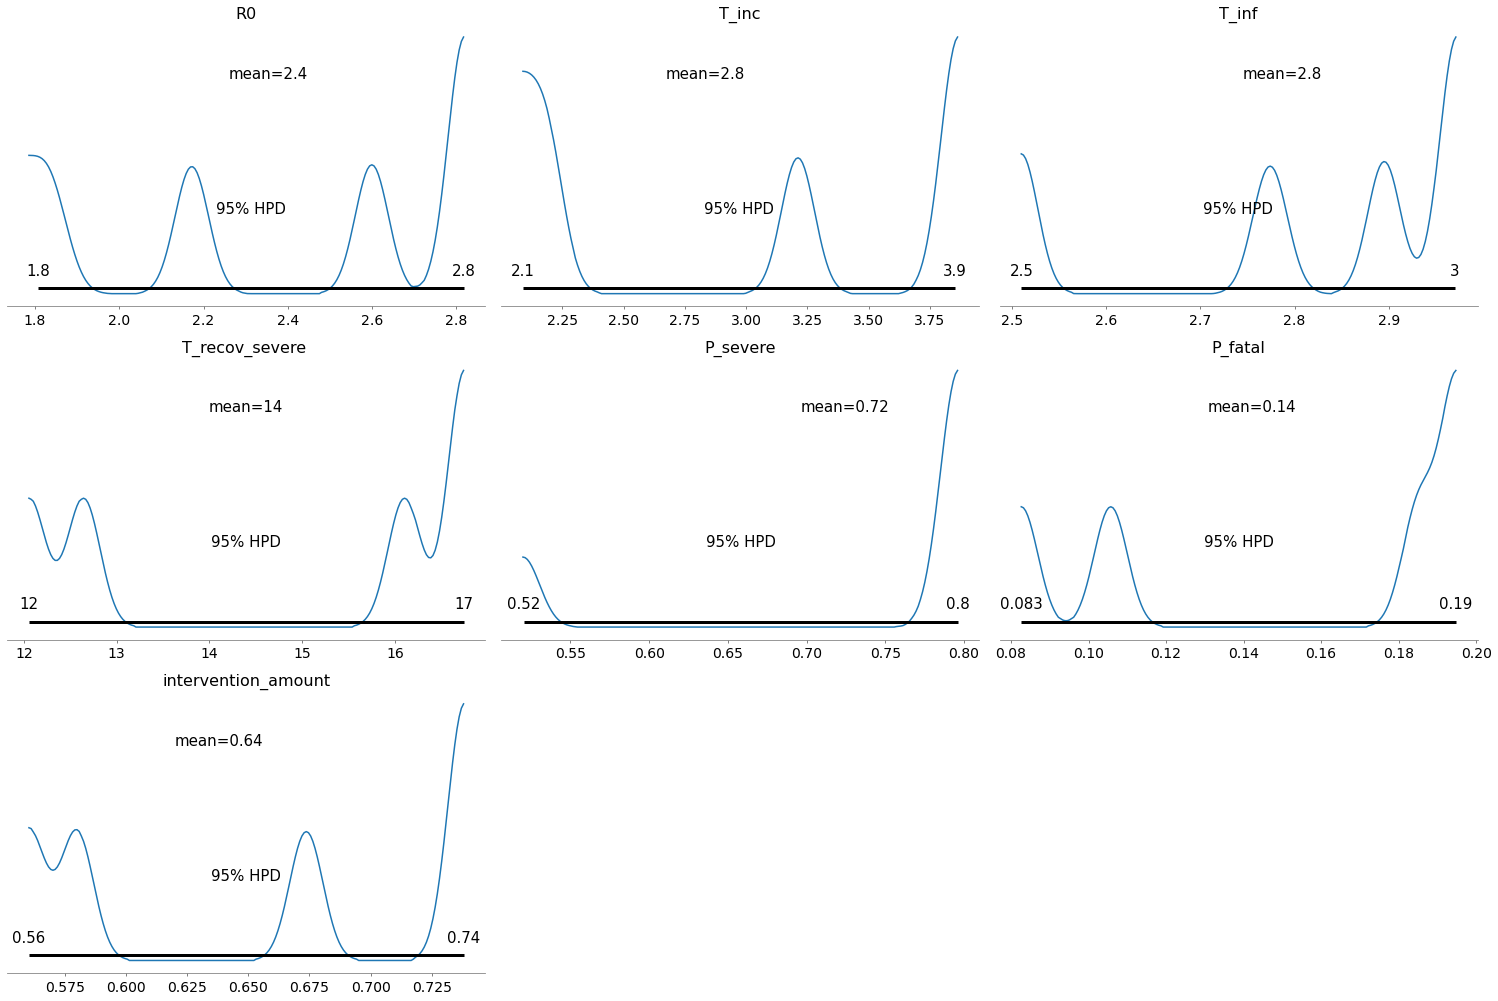

In [26]:
with model:
    data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)
    az.plot_posterior(data,round_to=2, credible_interval=0.95)

In [ ]:
#pm.forestplot(trace)

In [27]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
R0,2.354,0.381,1.812,2.817,0.188,0.144,4.0,4.0,4.0,12.0,4.55
T_inc,2.835,0.727,2.089,3.850,0.360,0.275,4.0,4.0,4.0,12.0,4.55
T_inf,2.787,0.174,2.510,2.970,0.086,0.066,4.0,4.0,4.0,12.0,4.55
T_recov_severe,14.387,2.056,12.055,16.739,1.018,0.779,4.0,4.0,4.0,11.0,3.84
P_severe,0.725,0.117,0.521,0.796,0.058,0.044,4.0,4.0,4.0,12.0,4.55
P_fatal,0.142,0.049,0.083,0.195,0.024,0.018,4.0,4.0,4.0,11.0,4.55
intervention_amount,0.638,0.072,0.560,0.738,0.036,0.027,4.0,4.0,5.0,29.0,2.99


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x149d6e390>,
      dtype=object)

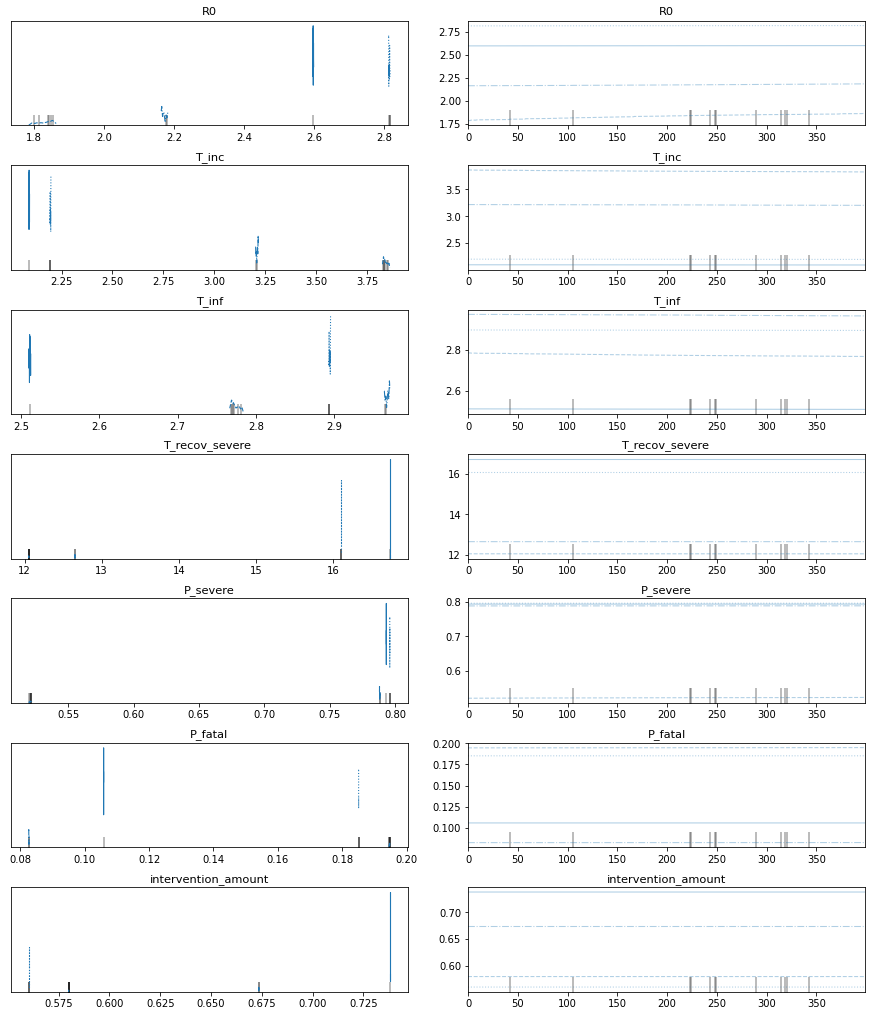

In [28]:
pm.plots.traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13d985780>,
      dtype=object)

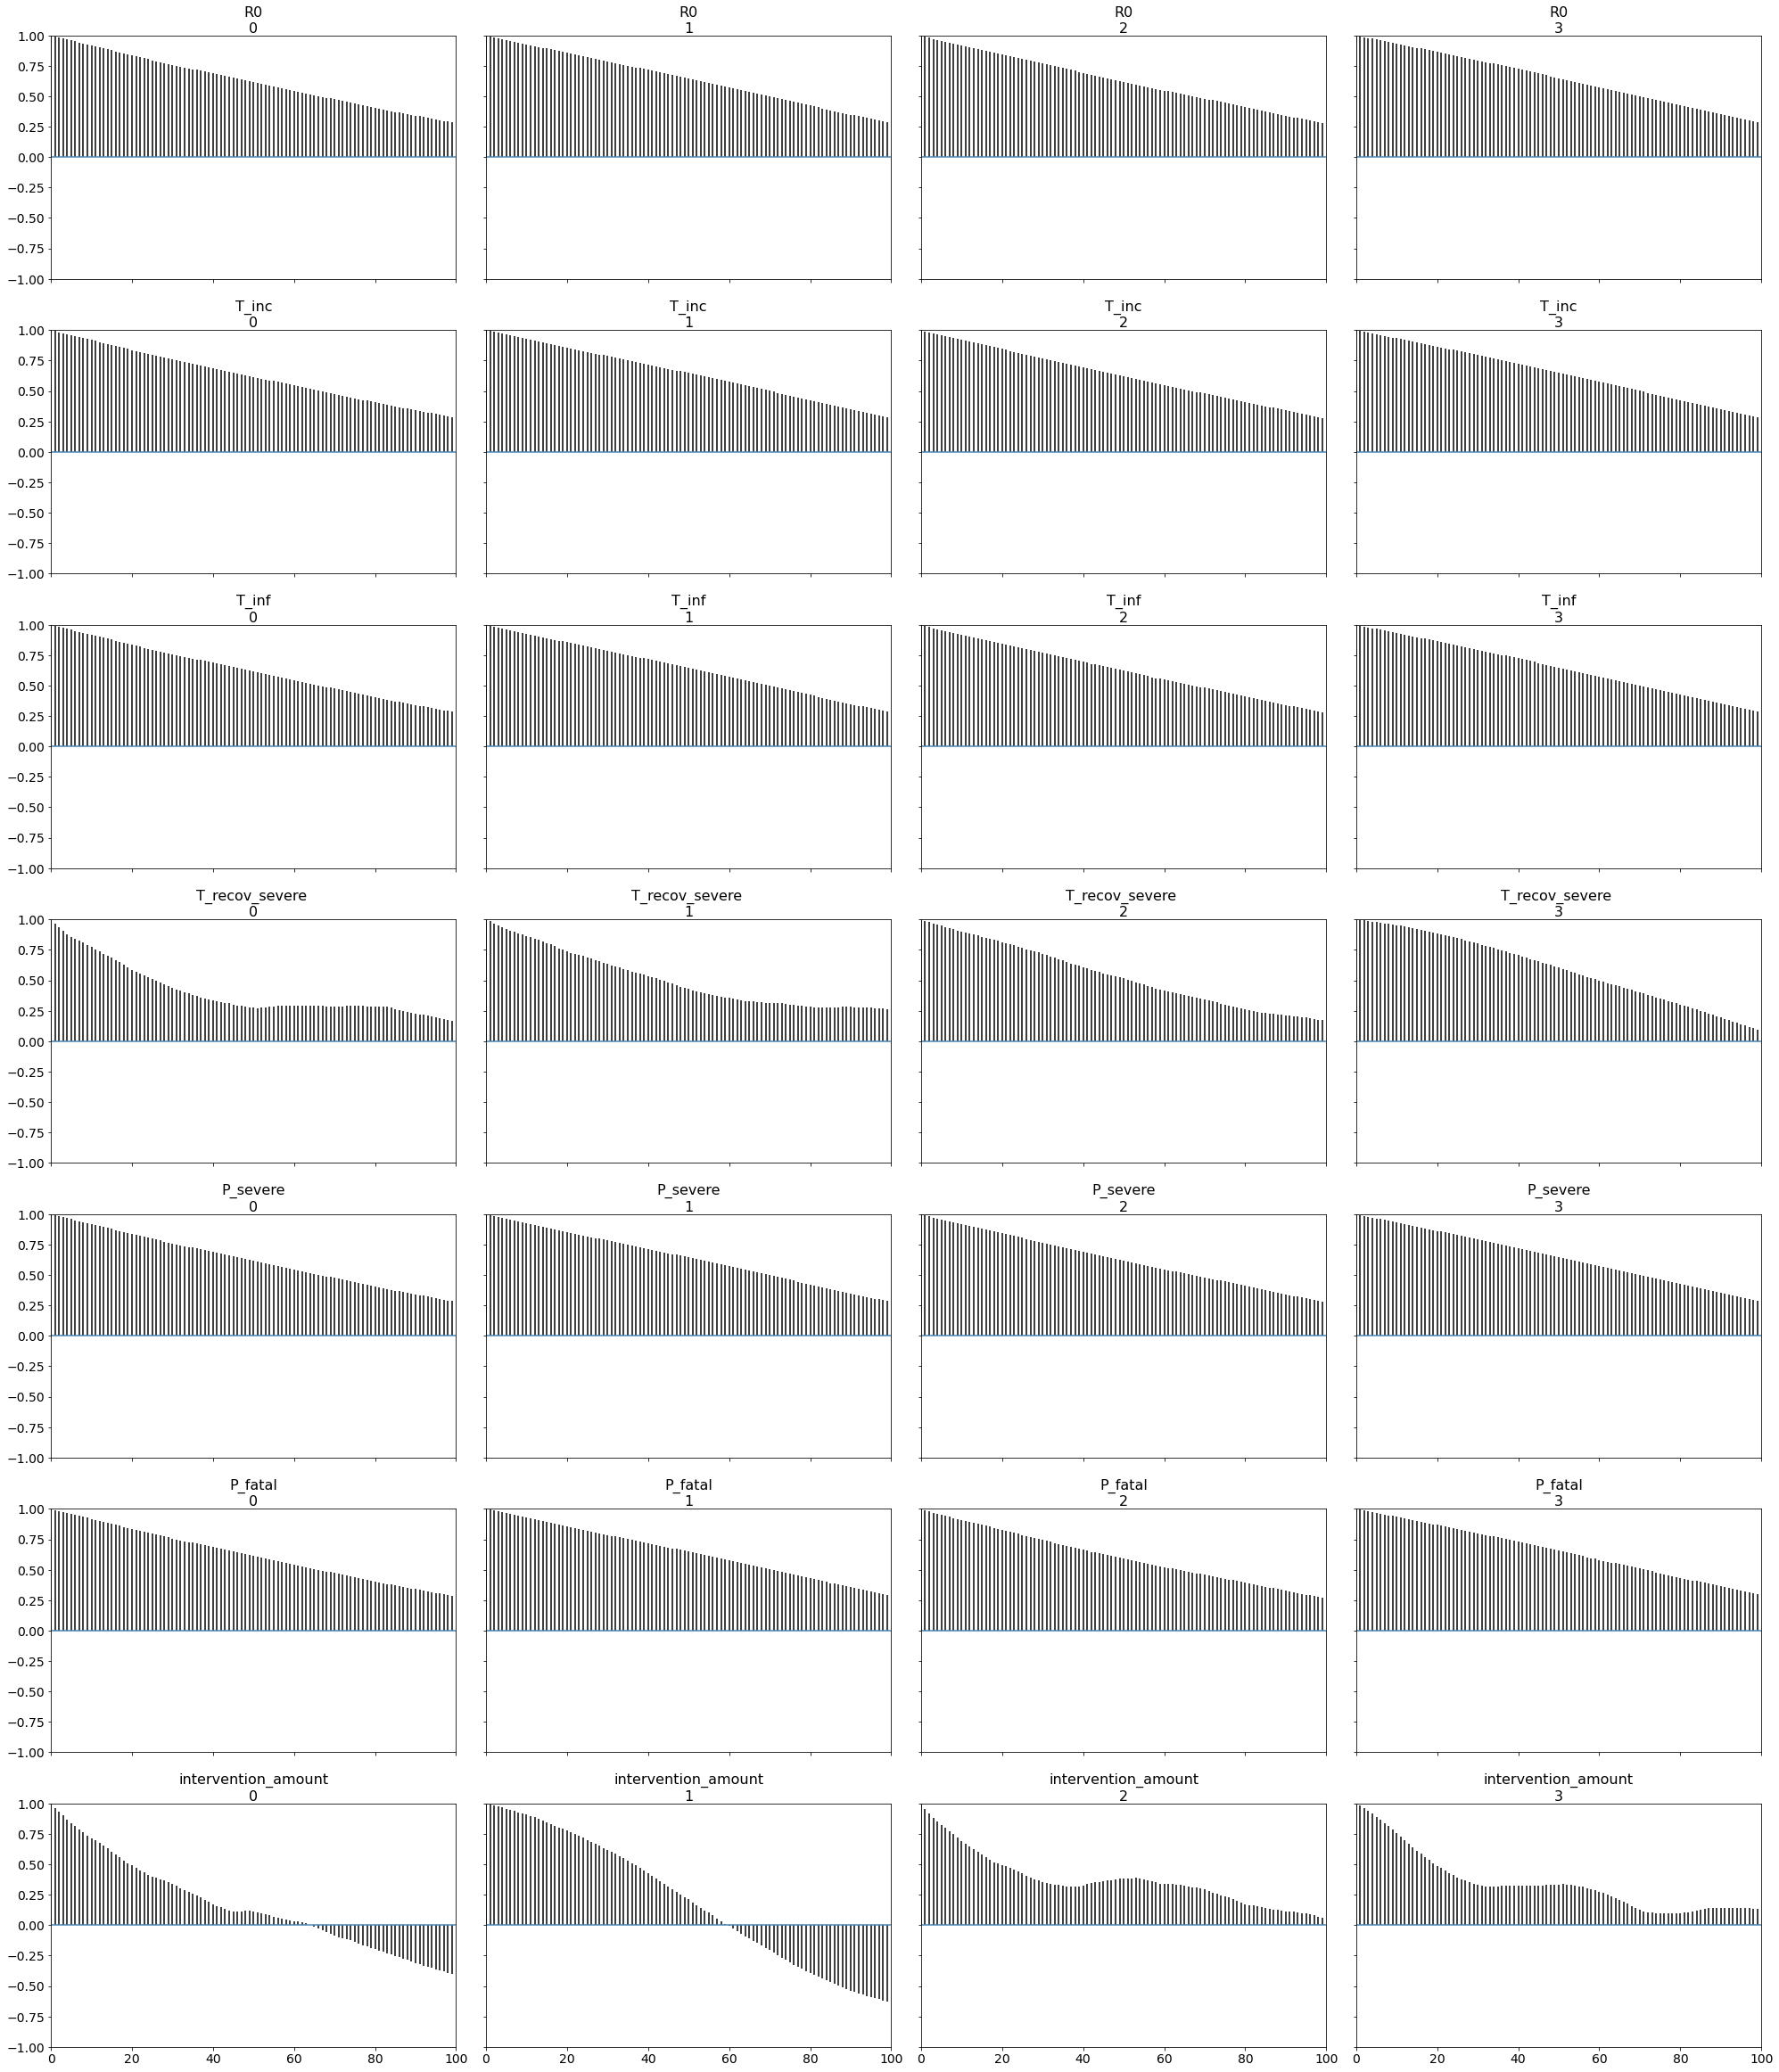

In [29]:
pm.plots.autocorrplot(trace)

In [ ]:
len(trace[500:])

In [57]:
default_params

{'N': 10000000.0,
 'init_infected': 4205,
 'intervention_day': -30,
 'intervention_removal_day': 24,
 'T_hosp': 0.001,
 'starting_date': Timestamp('2020-04-24 00:00:00')}

In [30]:
final_runs = trace#[burn_in:]

## Visualize the samples and intervals

In [72]:
#def visualize(): 
data_split = df_district.copy()
optimiser = Optimiser()
default_params = optimiser.init_default_params(data_split)

#combined_acc = list()
#for k, run in enumerate(mcmc):
#    burn_in = int(len(run) / 2)
#    combined_acc += run[0][burn_in:]

n_samples = 1000
sample_indices = np.random.uniform(0, len(final_runs), n_samples)

pred_dfs = list()
for i in tqdm(sample_indices):
    pred_dfs.append(optimiser.solve(final_runs[int(i)], 
                default_params, data_split, 
                initialisation = 'intermediate', 
                start_date = data_split.iloc[-num_train_steps, :].date,
                end_date= data_split.iloc[-1, :].date,
                hardcode_ratios = True, loss_indices = [-num_train_steps,0]))

for df in pred_dfs:
    df.set_index('date', inplace=True)

result = pred_dfs[0].copy()
for col in result.columns:
    result["{}_low".format(col)] = ''
    result["{}_high".format(col)] = ''

for date in tqdm(pred_dfs[0].index):
    for key in pred_dfs[0]:
        result.loc[date, key], result.loc[date, "{}_low".format(key)], result.loc[date, "{}_high".format(key)] = get_PI(pred_dfs, date, key)

data_split.set_index("date", inplace=True)


100%|██████████| 7/7 [00:01<00:00,  4.17it/s]


In [73]:
final_runs[int(i)],

({'R0_interval__': -0.13624771628515192,
  'T_inc_interval__': 0.21679839861697678,
  'T_inf_interval__': 0.6496319990364084,
  'T_recov_severe _interval__': -0.6982717117371324,
  'P_severe_interval__': 0.8819027268820214,
  'P_fatal_interval__': -0.9683441940167766,
  'intervention_amount_interval__': 0.13466943153673883,
  'R0': 2.1649766637812307,
  'T_inc': 3.2159532158985686,
  'T_inf': 2.9707825891193433,
  'T_recov_severe ': 12.654150751989208,
  'P_severe': 0.7879792867642813,
  'P_fatal': 0.08263567767124642,
  'intervention_amount': 0.6735315974591205},)

In [75]:
data_split['total_infected']

date
2020-04-24     4205
2020-04-25     5049
2020-04-26     5407
2020-04-27     5407
2020-04-28     6169
2020-04-29     6644
2020-04-30     7061
2020-05-01     7061
2020-05-02     8359
2020-05-03     8800
2020-05-04     8800
2020-05-05     9945
2020-05-06    10714
2020-05-07    11394
2020-05-08    12142
2020-05-09    12864
2020-05-10    13739
2020-05-11    14521
2020-05-12    14947
2020-05-13    15747
2020-05-14    16738
2020-05-15    17671
2020-05-16    18555
2020-05-17    20150
2020-05-18    21335
2020-05-19    21335
2020-05-20    24118
2020-05-21    25500
2020-05-22    27251
2020-05-23    28817
2020-05-24    30542
2020-05-25    31972
2020-05-26    32974
2020-05-27    34018
2020-05-28    35485
2020-05-29    35485
2020-05-30    38442
2020-05-31    38442
Name: total_infected, dtype: object

In [76]:
result['hospitalised']

date
2020-05-25    23862.000
2020-05-26    26761.175
2020-05-27    30927.337
2020-05-28    35847.456
2020-05-29    41272.520
2020-05-30    47097.572
2020-05-31    53279.646
Name: hospitalised, dtype: float64

In [77]:
pred_dfs[-1]

,S,E,I,D_E,D_I,R_mild,R_severe_home,R_severe_hosp,R_fatal,C,D,hospitalised,recovered,deceased,infectious_unknown,total_infected
date,,,,,,,,,,,,,,,,
2020-05-25,9922688,35794,9545,0,0,0,0,21598,2264,7083,1026,23862,7083,1026,9545,31971
2020-05-26,9916432,31670,15599,0,0,536,4,24203,2547,7903,1100,26754,7903,1100,15599,35757
2020-05-27,9907879,30595,19310,0,0,1223,5,27953,2950,8894,1186,30908,8894,1186,19310,40988
2020-05-28,9897829,31086,21910,0,0,1979,5,32381,3426,10095,1285,35812,10095,1285,21910,47192
2020-05-29,9886666,32393,24027,0,0,2765,6,37259,3950,11529,1401,41215,11529,1401,24027,54145
2020-05-30,9874542,34177,25952,0,0,3567,6,42493,4514,13213,1533,47013,13213,1533,25952,61759
2020-05-31,9861514,36260,27843,0,0,4378,7,48040,5111,15159,1683,53158,15159,1683,27843,70000


# Plot graphs

In [ ]:
#result['total_infected'], data_split['total_infected']

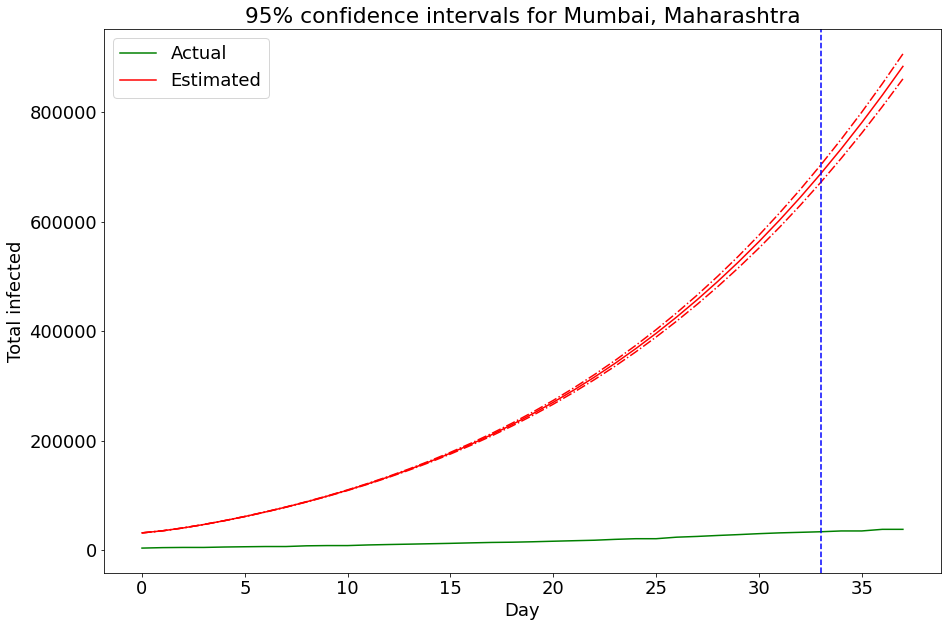

In [67]:
#x_plot = range(len(df_train) - len(observed)-7, len(df_train) - len(observed) + num_steps)
plt.figure(figsize=(15, 10))
plt.plot(data_split['total_infected'].tolist(), c='g', label='Actual')
plt.plot( result['total_infected'].tolist(), c='r', label='Estimated')
plt.plot( result['total_infected_low'].tolist(), c='r', linestyle='dashdot')
plt.plot( result['total_infected_high'].tolist(), c='r', linestyle='dashdot')
plt.axvline(x=len(df_train), c='b', linestyle='dashed')
plt.xlabel("Day")
plt.ylabel("Total infected")
plt.legend()
plt.title("95% confidence intervals for {}, {}".format(district, state))

plt.savefig('./mcmc_confidence_intervals_{}_{}.png'.format(district, state))
plt.show()

In [ ]:
visualize()